# Churn Modeling with Logistic Regression (New Features)

This notebook recreates the LR workflow using the uploaded dataset `cleaned_sales.csv` and the requested features:

- `avg_spend`, `total_spend`, `avg_items`, `marketing_optin`,
- `n_discounts`, `avg_discount`, `frequency`, `monetary`, `avg_gap_days`

Target label: `churn_label` (1 = no purchase in last 180 days, 0 = retained).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

## 1. Load data and quick check

In [4]:
raw_path = "/Users/victor/Desktop/cleaned_sales.csv"
df = pd.read_csv(raw_path)
print('Shape:', df.shape)
df.head(5)

Shape: (77490, 79)


,Order,Email,Financial.Status,Paid.at,Fulfillment.Status,Fulfilled.at,Accepts.Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount.Code,Discount.Amount,Shipping.Method,Created.at,Lineitem.quantity,Lineitem.name,Lineitem.price,Lineitem.compare.at.price,Lineitem.sku,Lineitem.requires.shipping,Lineitem.taxable,Lineitem.fulfillment.status,X,X.1,X.2,X.3,X.4,Billing.City,Billing.Zip,Billing.Province,Billing.Country,X.5,X.6,X.7,X.8,X.9,X.10,Shipping.City,Shipping.Zip,Shipping.Province,Shipping.Country,X.11,Notes,Note.Attributes,Cancelled.at,Payment.Method,Payment.Reference,Refunded.Amount,Vendor,Outstanding.Balance,Employee,Location,Device.ID,Id,Tags,Risk.Level,Source,Lineitem.discount,Tax.1.Name,Tax.1.Value,Tax.2.Name,Tax.2.Value,Tax.3.Name,Tax.3.Value,Tax.4.Name,Tax.4.Value,Tax.5.Name,Tax.5.Value,X.12,Receipt.Number,Duties,Billing.Province.Name,Shipping.Province.Name,Payment.ID,Payment.Terms.Name,Next.Payment.Due.At,Payment.References
0,113272,gcarruyo169@gmail.com,paid,9/30/2025 14:58,unfulfilled,NaN,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,9/30/2025 14:58,2,JOOLA Replacement White Ridge Grip (2 Pack),15.95,15.95,18558,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA-USA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...
1,113272,gcarruyo169@gmail.com,paid,9/30/2025 14:58,unfulfilled,NaN,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,9/30/2025 14:58,1,JOOLA Premium Pickleball Paddle Overgrip (4 Co...,9.95,9.95,18543,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA-USA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...
2,113272,gcarruyo169@gmail.com,paid,9/30/2025 14:58,unfulfilled,NaN,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,9/30/2025 14:58,1,JOOLA Pro IV Pickleball Edge Guard Tape - 30 /...,12.95,12.95,17319,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...
3,113271,teamrowe@comcast.net,paid,9/30/2025 14:35,unfulfilled,NaN,yes,USD,69.90,0.0,6.68,76.58,NaN,0.00,Free shipping over $50,9/30/2025 14:35,2,JOOLA Red Carbon CTR Table Tennis Racket,34.95,34.95,54222,True,True,pending,NaN,NaN,NaN,NaN,NaN,Park City,84060,UT,US,NaN,NaN,NaN,NaN,NaN,NaN,Park City,84060,UT,US,NaN,NaN,NaN,NaN,Shopify Payments,rz4m4Ri3yA0EHyJZ7xrzKoqHJ,0.0,JOOLA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,UT CITY TAX - PARK CITY 1.9%,1.33,UT COUNTY TAX - SUMMIT 2.8%,1.96,UT SPECIAL TAX - PARK CITY SP 0%,0.00,UT SPECIAL TAX - SUMMIT CO TR 0%,0.00,UT STATE TAX - UTAH 4.85%,3.39,NaN,NaN,NaN,Utah,Utah,rz4m4Ri3yA0EHyJZ7xrzKoqHJ,NaN,NaN,rz4m4Ri3yA0EHyJZ7xrzKoqHJ
4,113270,jennmckenzie106@gmail.com,paid,9/30/2025 14:33,unfulfilled,8/7/2025 12:46,yes,USD,705.70,0.0,68.82,774.52,FREEPULLOVER,29.95,Free shipping over $50,9/30/2025 14:33,1,Women's Court Tank - XS / White,39.95,39.95,300331,True,True,pending,NaN,NaN,NaN,NaN,NaN,Nashville,37205,TN,US,NaN,NaN,NaN,NaN,NaN,NaN,Nashville,37205,TN,US,NaN,Prioritize 2-Day Shipping for all orders above...,__freegift_attributes: SECOMAPP_FREEGIFT\n__bo

## 2. Basic cleaning and typing

In [7]:
# Keep rows with Email and parse dates
df = df[~df['Email'].isna()].copy()
for col in ['Paid.at','Created.at','Fulfilled.at']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Numeric coercion
for c in ['Total','Subtotal','Shipping','Taxes','Discount.Amount','Lineitem.quantity','Lineitem.price']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

# Order key
order_col = 'Order'
if order_col not in df.columns:
    df[order_col] = (df['Email'].astype(str)+'|'+df['Created.at'].astype(str)).astype('category').cat.codes

df.head(3)

,Order,Email,Financial.Status,Paid.at,Fulfillment.Status,Fulfilled.at,Accepts.Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount.Code,Discount.Amount,Shipping.Method,Created.at,Lineitem.quantity,Lineitem.name,Lineitem.price,Lineitem.compare.at.price,Lineitem.sku,Lineitem.requires.shipping,Lineitem.taxable,Lineitem.fulfillment.status,X,X.1,X.2,X.3,X.4,Billing.City,Billing.Zip,Billing.Province,Billing.Country,X.5,X.6,X.7,X.8,X.9,X.10,Shipping.City,Shipping.Zip,Shipping.Province,Shipping.Country,X.11,Notes,Note.Attributes,Cancelled.at,Payment.Method,Payment.Reference,Refunded.Amount,Vendor,Outstanding.Balance,Employee,Location,Device.ID,Id,Tags,Risk.Level,Source,Lineitem.discount,Tax.1.Name,Tax.1.Value,Tax.2.Name,Tax.2.Value,Tax.3.Name,Tax.3.Value,Tax.4.Name,Tax.4.Value,Tax.5.Name,Tax.5.Value,X.12,Receipt.Number,Duties,Billing.Province.Name,Shipping.Province.Name,Payment.ID,Payment.Terms.Name,Next.Payment.Due.At,Payment.References
0,113272,gcarruyo169@gmail.com,paid,2025-09-30 14:58:00,unfulfilled,NaT,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,2025-09-30 14:58:00,2,JOOLA Replacement White Ridge Grip (2 Pack),15.95,15.95,18558,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA-USA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...
1,113272,gcarruyo169@gmail.com,paid,2025-09-30 14:58:00,unfulfilled,NaT,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,2025-09-30 14:58:00,1,JOOLA Premium Pickleball Paddle Overgrip (4 Co...,9.95,9.95,18543,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA-USA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...
2,113272,gcarruyo169@gmail.com,paid,2025-09-30 14:58:00,unfulfilled,NaT,yes,USD,50.62,0.0,4.17,54.79,WELCOME10TEAMJOOLA,4.18,Free shipping over $50,2025-09-30 14:58:00,1,JOOLA Pro IV Pickleball Edge Guard Tape - 30 /...,12.95,12.95,17319,True,True,pending,NaN,NaN,NaN,NaN,NaN,Aubrey,76227,TX,US,NaN,NaN,NaN,NaN,NaN,NaN,Krugerville,76227,TX,US,NaN,NaN,NaN,NaN,Shopify Payments,rWdeMwPujWqbaP2I6I57mYb5w,0.0,JOOLA,0.0,NaN,NaN,NaN,6.190000e+12,NaN,Low,web,0.0,TX CITY TAX - LITTLE ELM 2%,1.01,TX STATE TAX - TEXAS 6.25%,3.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Texas,rWdeMwPujWqbaP2I6I57mYb5w,NaN,NaN,rlmoZ0uaccAlBOnQ4NdIK6yah + rWdeMwPujWqbaP2I6I...


## 3. Build order-level aggregates

In [10]:
order_items = df.groupby([order_col,'Email'], dropna=False)['Lineitem.quantity'].sum().rename('items_in_order').reset_index()
order_totals = df.groupby([order_col,'Email'], dropna=False)['Total'].max().rename('order_total').reset_index()
order_discounts = df.groupby([order_col,'Email'], dropna=False)['Discount.Amount'].sum().rename('order_discount').reset_index()
order_paid = df.groupby([order_col,'Email'], dropna=False)['Paid.at'].min().rename('paid_at').reset_index()

orders = (order_items
          .merge(order_totals, on=[order_col,'Email'], how='outer')
          .merge(order_discounts, on=[order_col,'Email'], how='outer')
          .merge(order_paid, on=[order_col,'Email'], how='outer'))
orders.head(5)

,Order,Email,items_in_order,order_total,order_discount,paid_at
0,51050,ptai@sport-squad.com,1,107.56,0.00,2024-07-11 01:34:00
1,51052,berinozishe@hotmail.com,7,1399.65,0.00,2024-07-11 01:52:00
2,51054,seancgram@gmail.com,1,199.95,0.00,2024-07-11 03:45:00
3,51055,amer+wotio@praella.com,3,122.03,0.00,2024-07-11 04:35:00
4,51056,sandip.k+3@praella.com,1,25.16,13.97,2024-07-11 05:55:00


## 4. Customer-level features

In [13]:
def to_bool_optin(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    return 1 if s in ('true','t','1','yes','y','accepted','accepts','opt-in','optin') else 0

optin_series = df['Accepts.Marketing'].map(to_bool_optin) if 'Accepts.Marketing' in df.columns else pd.Series([np.nan]*len(df))
cust_optin = (pd.DataFrame({'Email': df['Email'], 'optin': optin_series})
             .groupby('Email', dropna=False)['optin']
             .max()
             .rename('marketing_optin')
             .reset_index()
             .fillna({'marketing_optin': 0}))

cust_agg = (orders.groupby('Email', dropna=False)
    .agg(total_spend=('order_total','sum'),
         avg_spend=('order_total','mean'),
         avg_items=('items_in_order','mean'),
         n_discounts=('order_discount', lambda x: np.sum(x.fillna(0) > 0)),
         avg_discount=('order_discount', lambda x: x.replace(0, np.nan).mean() if (~x.isna()).any() else 0.0),
         frequency=('paid_at','count'),
         first_purchase=('paid_at','min'),
         last_purchase=('paid_at','max'),
         monetary=('order_total','sum')).reset_index())

def avg_gaps(g):
    g = g.dropna().sort_values()
    if len(g) < 2:
        return np.nan
    diffs = g.diff().dropna().dt.days
    return float(diffs.mean()) if len(diffs) else np.nan

gap_df = (orders.sort_values(['Email','paid_at'])
          .groupby('Email', dropna=False)['paid_at']
          .apply(avg_gaps)
          .rename('avg_gap_days')
          .reset_index())

features = cust_agg.merge(cust_optin, on='Email', how='left').merge(gap_df, on='Email', how='left')
features['avg_items'] = features['avg_items'].fillna(0)
features['avg_discount'] = features['avg_discount'].fillna(0)
features['avg_gap_days'] = features['avg_gap_days'].fillna(features['avg_gap_days'].median())
features.head(5)

,Email,total_spend,avg_spend,avg_items,n_discounts,avg_discount,frequency,first_purchase,last_purchase,monetary,marketing_optin,avg_gap_days
0,007armin@gmail.com,297.45,297.450,1.0,0,0.00,1,2025-05-05 06:48:00,2025-05-05 06:48:00,297.45,1,59.500000
1,00chuey@gmail.com,151.12,151.120,1.0,1,139.97,1,2025-03-18 14:17:00,2025-03-18 14:17:00,151.12,1,59.500000
2,012345blc@gmail.com,518.86,129.715,3.0,1,11.97,4,2025-04-19 13:51:00,2025-08-26 22:56:00,518.86,0,42.666667
3,0147350@gmail.com,299.55,299.550,1.0,0,0.00,1,2024-08-14 09:45:00,2024-08-14 09:45:00,299.55,1,59.500000
4,041carol@gmail.com,233.08,116.540,1.5,1,139.97,2,2025-03-17 15:25:00,2025-05-14 18:28:00,233.08,0,58.000000


## 5. Label: churn if no purchase in last 180 days

In [18]:
max_date = df['Paid.at'].max()
cutoff_days = 180
features['churn_label'] = (max_date - features['last_purchase']).dt.days > cutoff_days
features['churn_label'] = features['churn_label'].fillna(True).astype(int)

keep_cols = ['Email','avg_spend','total_spend','avg_items','marketing_optin',
             'n_discounts','avg_discount','frequency','monetary','avg_gap_days','churn_label']
data = features[keep_cols].copy()
data.to_csv("/Users/victor/Desktop/new_sales.csv", index=False)
data.head(10)

,Email,avg_spend,total_spend,avg_items,marketing_optin,n_discounts,avg_discount,frequency,monetary,avg_gap_days,churn_label
0,007armin@gmail.com,297.450,297.45,1.0,1,0,0.00,1,297.45,59.500000,0
1,00chuey@gmail.com,151.120,151.12,1.0,1,1,139.97,1,151.12,59.500000,1
2,012345blc@gmail.com,129.715,518.86,3.0,0,1,11.97,4,518.86,42.666667,0
3,0147350@gmail.com,299.550,299.55,1.0,1,0,0.00,1,299.55,59.500000,1
4,041carol@gmail.com,116.540,233.08,1.5,0,1,139.97,2,233.08,58.000000,0
5,050107jcc@gmail.com,254.495,1017.98,1.0,1,1,139.97,4,1017.98,92.666667,0
6,05kevincruz@gmail.com,164.768,823.84,1.4,1,0,0.00,5,823.84,49.500000,0
7,05krishna22@gmail.com,97.790,97.79,2.0,0,1,59.94,1,97.79,59.500000,1
8,07swim11@gmail.com,279.950,279.95,1.0,0,0,0.00,1,279.95,59.500000,1
9,08051997tr@gmail.com,32.580,32.58,1.0,1,0,0.00,1,32.58,59.500000,1


## 6. Train/test split and Logistic Regression

In [21]:
feature_cols = ['avg_spend','total_spend','avg_items','marketing_optin',
                'n_discounts','avg_discount','frequency','monetary','avg_gap_days']
X = data[feature_cols].copy()
y = data['churn_label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('lr', LogisticRegression(max_iter=200, class_weight='balanced', solver='lbfgs'))
])
pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
acc = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary')
cm = confusion_matrix(y_test, pred)

print('AUC:', round(auc, 4))
print('Accuracy:', round(acc, 4))
print('Precision:', round(prec, 4))
print('Recall:', round(rec, 4))
print('F1:', round(f1, 4))
print('Confusion Matrix:\n', cm)

AUC: 0.569
Accuracy: 0.528
Precision: 0.5129
Recall: 0.6509
F1: 0.5737
Confusion Matrix:
 [[2000 2868]
 [1620 3020]]


## 7. Coefficients

In [26]:
coefs = pd.DataFrame({
    'feature': feature_cols,
    'coef': pipe.named_steps['lr'].coef_.ravel()
}).sort_values('coef', ascending=False)
coefs.to_csv("/Users/victor/Desktop/cof.csv", index=False)
coefs

,feature,coef
0,avg_spend,0.104235
3,marketing_optin,0.018925
1,total_spend,-0.005047
7,monetary,-0.005047
4,n_discounts,-0.029828
2,avg_items,-0.065955
8,avg_gap_days,-0.075446
5,avg_discount,-0.084968
6,frequency,-0.220336


## 8. ROC Curve

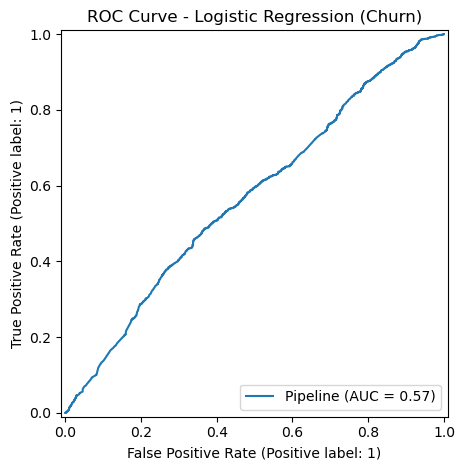

In [29]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title('ROC Curve - Logistic Regression (Churn)')
plt.tight_layout()
plt.show()

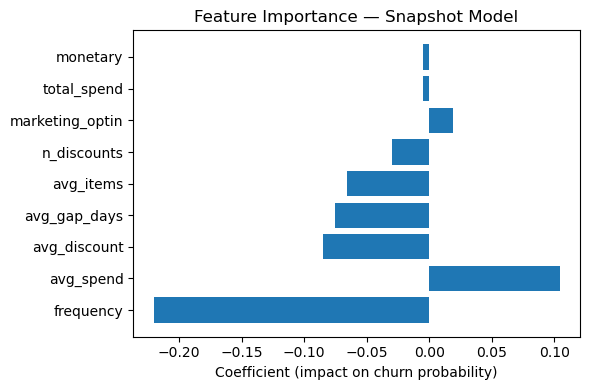

In [31]:
# Create coefficient dataframe
feature_cols = ['avg_spend', 'total_spend', 'avg_items', 'marketing_optin',
                'n_discounts', 'avg_discount', 'frequency', 'monetary', 'avg_gap_days']

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef': pipe.named_steps['lr'].coef_.ravel()
})
coef_df['abs_coef'] = coef_df['coef'].abs()

# Sort by absolute coefficient value (most impactful first)
top = coef_df.sort_values('abs_coef', ascending=False)

# Plot horizontal bar chart
plt.figure(figsize=(6,4))
plt.barh(top['feature'], top['coef'])
plt.title("Feature Importance — Snapshot Model")
plt.xlabel("Coefficient (impact on churn probability)")
plt.tight_layout()
plt.show()